In [1]:
"""
This note book analyzes how density AND LID together relate to reconstruction loss.
"""

'\nThis note book analyzes how density AND LID together relate to reconstruction loss.\n'

In [36]:
import json
import os
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
sys.path.append(os.path.abspath("../../.."))   # one level up from notebook/
from sklearn.linear_model import LinearRegression
import numpy as np
from data.utils.dataloaders import ReconstructionDataset_Heuristic
import numpy as np
from sklearn.linear_model import LinearRegression
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
def prepare_reconstruction_dataset(reconst_loss_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json",
                                   LID_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/original_images/val/",
                                   best_LID_noise_level=[26,26,25,25,24,24,23,14,14],
                                   local_density_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/val",
                                   k_values = [1,2,4,8,16,32,64,128,256]):
    
    """
    Read the reconstruction loss file, LID values for best noise levels, and local density information.
    Create and return a ReconstructionDataset_Heuristic instance.
    """
    # read reconstruction loss json file 
    with open(reconst_loss_file, 'r') as f:
        reconst_losses = json.load(f)

    # read LID values for best noise levels
    best_lids_per_k = {}
    for best_lid, k in zip(best_LID_noise_level, k_values):
        LID_JSON   = f"/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/original_images/val/t_{best_lid}/lid_0000_3125.json"
        # Load LID values; we assume it's ordered so that index i corresponds to image i
        with open(LID_JSON, 'r') as f:
            lid_values = json.load(f)
        best_lids_per_k[k] = lid_values

    # load densities
    density_dict = {}
    for k in k_values:
        with open((local_density_file + f"/reconst_{k}_combined_token_count256.json"), 'r') as f:
            current_densities = json.load(f)
        density_dict[k]=current_densities

    processed_density_dict = {}
    timestep_needed = [0,0,0,0,0,0,0,0,0]
    for idx, (key, value) in enumerate(density_dict.items()):
        processed_density_dict[key] = [sum(v[0][timestep_needed[idx]:]) for v in value]

    # create dataset
    ds = ReconstructionDataset_Heuristic(
        reconstruction_data=reconst_losses,  # or your processed list of dicts
        local_density_information=processed_density_dict, # [l[0] for l in density]
        lid_information=best_lids_per_k,
        error_key=["LPIPS"],
    )

    return ds

In [37]:
def fit_models_per_k(loader, k_values):

    per_k = {int(k): {"densities": [], "lids": [], "losses": []} for k in k_values}

    for batch in loader:
        losses = np.asarray(batch["LPIPS"], dtype=float)
        densities = np.asarray(batch["local_density"], dtype=float)
        lids = np.asarray(batch["lid"], dtype=float)
        ks = np.asarray(batch["k_value"], dtype=int)

        for i, k in enumerate(ks):
            per_k[k]["densities"].append(densities[i])
            per_k[k]["lids"].append(lids[i])
            per_k[k]["losses"].append(losses[i])

    models = {}
    for k in k_values:
        d = per_k[k]
        X = np.stack([d["densities"], d["lids"]], axis=1)
        y = np.array(d["losses"], dtype=float)

        model = Pipeline([
            ("scaler", StandardScaler()),
            ("reg", LinearRegression(fit_intercept=True))
        ])

        model.fit(X, y)
        models[k] = model

    return models

In [5]:
def find_bins(ds, k_values, num_bins=10, binning="quantile", normalize="prob"):
    """
    Find bin edges for reconstruction losses in the dataset.
    binning can be 'quantile' or 'uniform'.
    quantile: bins have equal number of samples
    uniform: bins have equal width
    """
    k_values = [int(k) for k in k_values]
    k_to_row = {k:i for i,k in enumerate(k_values)}

    losses = np.array([float(d["LPIPS"]) for d in ds], dtype=float)
    ks     = np.array([int(d["k_value"]) for d in ds], dtype=int)

    # bins on loss
    if binning == "quantile":
        q = np.linspace(0, 1, num_bins + 1)
        bin_edges = np.quantile(losses, q)
    elif binning == "uniform":
        bin_edges = np.linspace(losses.min(), losses.max(), num_bins + 1)
    else:
        raise ValueError("binning must be 'quantile' or 'uniform'")

    bin_edges[0]  -= 1e-9
    bin_edges[-1] += 1e-9

    # matrix [num_k, num_bins]
    token_prob_across_recon_loss = np.zeros((len(k_values), num_bins), dtype=float)
    for loss, k in zip(losses, ks):
        b = int(np.searchsorted(bin_edges, loss, side="right") - 1)
        b = max(0, min(b, num_bins - 1))
        token_prob_across_recon_loss[k_to_row[k], b] += 1

    if normalize == "prob":
        col_sums = token_prob_across_recon_loss.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1.0
        token_prob_across_recon_loss = token_prob_across_recon_loss / col_sums

    return bin_edges, token_prob_across_recon_loss

In [6]:
def plot_k_vs_loss_heatmap(bin_edges, M, k_values, num_bins=10, normalize="prob"):
    """
    Heatmap of token distribution across LPIPS bins.
      x-axis: LPIPS bins
      y-axis: k values
      color : count or probability

    normalize:
      - "count": show raw counts
      - "prob":  show per-bin probabilities (each column sums to 1)
    """
    

    # x labels
    x_labels = [f"[{bin_edges[i]:.3f}, {bin_edges[i+1]:.3f}]" for i in range(num_bins)]

    plt.figure(figsize=(12, 5))
    plt.imshow(M, aspect="auto", origin="lower")
    plt.colorbar(label=("Probability" if normalize=="prob" else "Count"))

    plt.xticks(range(num_bins), x_labels, rotation=45, ha="right")
    plt.yticks(range(len(k_values)), [str(k) for k in k_values])

    plt.xlabel("Reconstruction loss (LPIPS) bins")
    plt.ylabel("Token count (k)")
    plt.title("P(k | loss bin)" if normalize=="prob" else "Counts of k per loss bin")
    plt.tight_layout()
    plt.show()


In [ ]:
def conditioned_k_distribution(loader, models, k_values, tau=0.02):
    """
    Compute a conditioned distribution over k for batched data from a DataLoader/Dataset.

    For each sample with features (density, lid) and observed LPIPS loss:
      - For every k in k_values that has a fitted model, predict LPIPS.
      - Compute error = |pred_lpips(k) - loss|.
      - Convert errors to weights via softmin: w_k = exp(-error / tau) and normalize.
    """


    # Helper: compute weights for a batch of samples given features and losses
    # based on how well each token count predicts the reconstruction loss.
    def _weights_for_batch(densities, lids, losses):
        X = np.stack([densities, lids], axis=1)  # [B, 2]
        # Build error matrix [B, len(ks)] by predicting per-k over the batch
        errs = np.zeros((X.shape[0], len(k_values)), dtype=float)
        for j, k in enumerate(k_values):
            yhat = models[k].predict(X)  # [B]
            errs[:, j] = np.abs(yhat - losses)
        W = np.exp(-errs / float(tau))
        # Normalize per sample to sum to 1
        W_sum = W.sum(axis=1, keepdims=True)
        W_sum[W_sum == 0] = 1.0
        return W / W_sum


    all_weights = []
    for batch in loader:
        losses = np.asarray(batch["LPIPS"], dtype=float)
        densities = np.asarray(batch["local_density"], dtype=float)
        lids = np.asarray(batch["lid"], dtype=float)

        W = _weights_for_batch(densities, lids, losses)  # [B, len(ks)]
        all_weights.append(W)

    if len(all_weights) == 0:
        return k_values, np.zeros((0, len(k_values)), dtype=float)

    weights = np.vstack(all_weights)
    return k_values, weights

In [8]:
def per_bin_nll_baseline(loader, bin_edges, baseline_dist, k_to_idx):
    """
    Compute per-LPIPS-bin average NLL for the BASELINE using batched processing.

    Definition
    ----------
    For each sample with reconstruction loss `loss` and token count `true_k`:
      1) Assign LPIPS bin index b via `bin_edges`.
      2) Look up the baseline distribution p_base = baseline_dist[b] (vector over k).
      3) Read the true probability p_true = p_base[k_to_idx[true_k]].
      4) Accumulate NLL = -log(max(p_true, eps)).

    """

    num_bins = baseline_dist.shape[0]

    # Prepare aggregator arrays.
    sum_nll = np.zeros(num_bins, dtype=float)
    count = np.zeros(num_bins, dtype=int)


    eps = 1e-12

    for batch in loader:
        # dict-of-lists/tensors
        losses = np.asarray(batch["LPIPS"], dtype=float)
        true_k = np.asarray(batch["k_value"], dtype=int)

        # Bin assignment for the full batch.
        b_idx = np.searchsorted(bin_edges, losses, side="right") - 1
        b_idx = np.clip(b_idx, 0, num_bins - 1)

        # Map true_k -> column indices for baseline_mat.
        k_idx = np.fromiter((k_to_idx[int(k)] for k in true_k), dtype=int, count=len(true_k))

        # Gather p_true per sample and compute NLL.
        p_true = baseline_dist[b_idx, k_idx]
        nll = -np.log(p_true + eps)

        # Aggregate per bin using vectorized indexed adds.
        np.add.at(sum_nll, b_idx, nll)
        np.add.at(count, b_idx, 1)

    # Build rows per bin.
    rows = []
    for b in range(num_bins):
        if count[b] == 0:
            rows.append({
                "bin": b,
                "n": 0,
                "loss_range": (float(bin_edges[b]), float(bin_edges[b+1])),
                "baseline_nll": float("nan"),
            })
        else:
            rows.append({
                "bin": b,
                "n": int(count[b]),
                "loss_range": (float(bin_edges[b]), float(bin_edges[b+1])),
                "baseline_nll": float(sum_nll[b] / max(count[b], 1)),
            })

    return rows

# ----------------------------
# Baseline per-bin NLL
#   baseline_dist[b] is a prob vector over k_values for LPIPS bin b
# ----------------------------
def per_bin_nll_heuristic(loader, bin_edges, models, k_values, tau=0.02):
    """
    Compute per-LPIPS-bin average NLL for the heuristic method,
    leveraging `conditioned_k_distribution` to compute per-sample weights over k.

    Steps per sample:
      1) Assign LPIPS bin index b via `bin_edges`.
      2) Use `conditioned_k_distribution(loader, models, k_values, tau)` to get weights over k.
      3) Probability for the true k is the corresponding weight (0 if true_k not in modeled ks).
      4) Accumulate NLL = -log(max(p_true, eps)).
    """

    # Get modeled k subset and per-sample weights over k using the helper
    ks, weights = conditioned_k_distribution(loader, models, k_values, tau=tau)  # weights: [N, len(ks)]
    ks_pos = {int(k): j for j, k in enumerate(ks)}

    # Collect losses and true_k across the same loader (second pass)
    losses_list = []
    true_k_list = []
    for batch in loader:
        losses_list.append(np.asarray(batch["LPIPS"], dtype=float))
        true_k_list.append(np.asarray(batch["k_value"], dtype=int))

    if len(losses_list) == 0:
        return []

    losses = np.concatenate(losses_list)  # [N]
    true_k = np.concatenate(true_k_list)  # [N]

    # Bin indices
    num_bins = int(len(bin_edges) - 1)
    b_idx = np.searchsorted(bin_edges, losses, side="right") - 1
    b_idx = np.clip(b_idx, 0, num_bins - 1)

    # Probability of true k under the weights; 0 if true_k not in ks
    pos_idx = np.array([ks_pos.get(int(k), -1) for k in true_k], dtype=int)
    row_idx = np.arange(len(true_k))
    p_true = np.where(pos_idx >= 0, weights[row_idx, pos_idx], 0.0)

    # Aggregate NLL per bin
    eps = 1e-12
    nll = -np.log(p_true + eps)
    sum_nll = np.zeros(num_bins, dtype=float)
    count = np.zeros(num_bins, dtype=int)
    np.add.at(sum_nll, b_idx, nll)
    np.add.at(count, b_idx, 1)

    # Build rows
    rows = []
    for b in range(num_bins):
        if count[b] == 0:
            rows.append({
                "bin": b,
                "n": 0,
                "loss_range": (float(bin_edges[b]), float(bin_edges[b+1])),
                "heuristic_nll": float("nan"),
            })
        else:
            rows.append({
                "bin": b,
                "n": int(count[b]),
                "loss_range": (float(bin_edges[b]), float(bin_edges[b+1])),
                "heuristic_nll": float(sum_nll[b] / max(count[b], 1)),
            })

    return rows

# ----------------------------
# Merge baseline + heuristic per bin (nice for printing/plotting)
# ----------------------------
def merge_per_bin_nll(rows_base, rows_heur):
    """
    Merge per-bin NLL rows from baseline + heuristic into a single list of dicts.
    Assumes same binning.
    """
    out = []
    for rb, rh in zip(rows_base, rows_heur):
        out.append({
            "bin": rb["bin"],
            "n": rb["n"],  # should match rh["n"] if both computed on same ds filtering
            "loss_range": rb["loss_range"],
            "baseline_nll": rb["baseline_nll"],
            "heuristic_nll": rh["heuristic_nll"],
            "delta_nll": (rb["baseline_nll"] - rh["heuristic_nll"]),
        })
    return out

In [33]:
def plot_per_bin_nll(rows, title="Per-bin NLL: baseline vs method"):
    """
    Plot baseline vs method NLL per LPIPS bin, plus the delta (baseline - method).

    rows: list of dicts like:
      {
        'bin': int,
        'n': int,
        'loss_range': (lo, hi),
        'baseline_nll': float,
        'heuristic_nll': float,
        'delta_nll': float   # baseline - method
      }
    """
    rows = sorted(rows, key=lambda r: r["bin"])

    bins = np.array([r["bin"] for r in rows], dtype=int)
    
    base = np.array([r["baseline_nll"] for r in rows], dtype=float)
    meth = np.array([r["heuristic_nll"] for r in rows], dtype=float)

    xlabels = [f"[{r['loss_range'][0]:.3f},{r['loss_range'][1]:.3f}]" for r in rows]

    # --- Plot 1: baseline vs method NLL ---
    plt.figure(figsize=(10, 4))
    plt.plot(bins, base, marker="o", label="Baseline NLL")
    plt.plot(bins, meth, marker="o", label="Method NLL")
    plt.xticks(bins, xlabels, rotation=45, ha="right")
    plt.xlabel("Reconstruction loss (LPIPS) bins")
    plt.ylabel("NLL (lower is better)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
ds = prepare_reconstruction_dataset()
ds_loader = DataLoader(ds, batch_size=16)

In [34]:
k_values = [1,2,4,8,16,32,64,128,256]
k_to_idx = {k:i for i,k in enumerate(k_values)}

models = fit_models_per_k(ds_loader, k_values)
print("FITTED MODELS")

FITTED MODELS


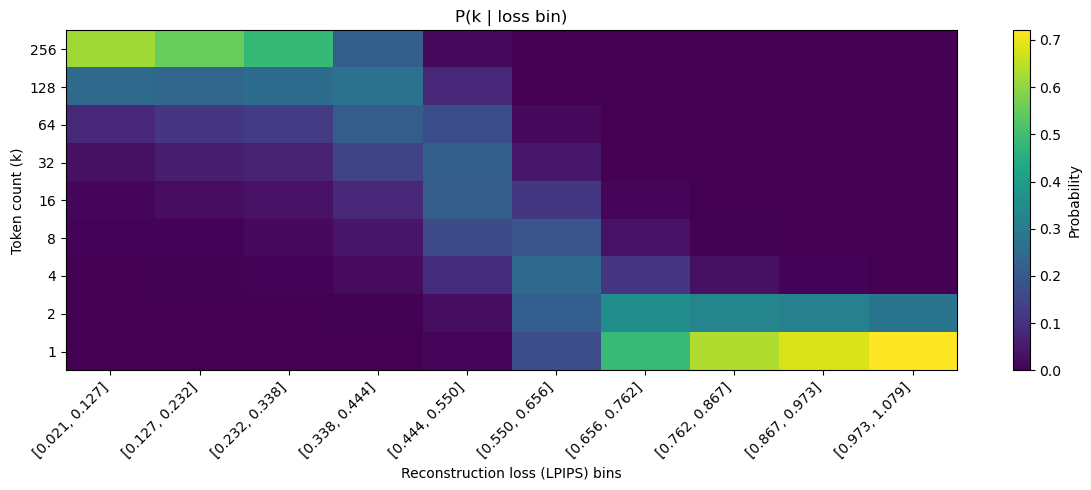

FOUND BINS and HEATMAP


In [35]:
# find the bins for reconstruction loss
bin_edges, token_prob_across_recon_loss = find_bins(ds, k_values, num_bins=10, binning="uniform", normalize="prob")

# baseline_dist[b] = probability vector over k for recon loss bin b
# probability is based on counts of k values in each bin normalized to sum to 1
baseline_dist = torch.stack([torch.tensor(token_prob_across_recon_loss[:, b]) for b in range(token_prob_across_recon_loss.shape[1])], dim=0)

plot_k_vs_loss_heatmap(bin_edges, token_prob_across_recon_loss, k_values, num_bins=10, normalize="prob")

print("FOUND BINS and HEATMAP")

In [ ]:
def find_best_tau_for_heuristic(tau_list, ds_loader, bin_edges, models, k_values):
    """
    For the heuristic method, we find the negative log-likelihood (NLL), which is our evaluation metric.
    For that we need to find a predicted distribution over k values. (see function conditioned_k_distribution)
    """

    num_bins = int(len(bin_edges) - 1)
    nll_various_taus = np.full((len(tau_list), num_bins), np.nan, dtype=float)
    counts_per_bin = None

    for ti, tau in enumerate(tau_list):
        rows_heuristic = per_bin_nll_heuristic(ds_loader, bin_edges, models, k_values, tau=tau)
        print(f"\n\n--- Tau={tau} ---")
        for row in rows_heuristic:
            b = int(row['bin'])
            if counts_per_bin is None:
                counts_per_bin = np.zeros(num_bins, dtype=int)
            counts_per_bin[b] = int(row['n'])
            nll = float(row['heuristic_nll']) if row['n'] > 0 else np.nan
            nll_various_taus[ti, b] = nll
            print(f"bin={row['bin']} | n={row['n']} | heuristic_nll={nll:.04f}")

    # pick best tau per bin (min NLL)
    best_idx_per_bin = np.nanargmin(nll_various_taus, axis=0)
    best_tau_per_bin = [tau_list[i] for i in best_idx_per_bin]
    best_nll_per_bin = [nll_various_taus[i, b] for b, i in enumerate(best_idx_per_bin)]

    return best_tau_per_bin, best_nll_per_bin, nll_various_taus

In [ ]:
rows_baselines = per_bin_nll_baseline(ds_loader, bin_edges, baseline_dist, k_to_idx)
tau_list = [0.01, 0.02, 0.05, 0.1, 0.2]
best_tau_per_bin, best_nll_per_bin, nll_various_taus = find_best_tau_for_heuristic(tau_list, ds_loader, bin_edges, models, k_values)
best_nlls = [np.nanmin(nll_various_taus[:, b]) for b in range(int(len(bin_edges) - 1))]

rows_heuristic = per_bin_nll_heuristic(ds_loader, bin_edges, models, k_values, tau=0.05)



Bin 00 n=  816 loss[0.021,0.127] | NLL base=1.063 method=1.610 | Δ(base-method)=-0.547
Bin 01 n= 9841 loss[0.127,0.232] | NLL base=1.236 method=1.738 | Δ(base-method)=-0.502
Bin 02 n=43865 loss[0.232,0.338] | NLL base=1.388 method=1.553 | Δ(base-method)=-0.165
Bin 03 n=96329 loss[0.338,0.444] | NLL base=1.747 method=1.496 | Δ(base-method)=0.252
Bin 04 n=120271 loss[0.444,0.550] | NLL base=1.908 method=1.796 | Δ(base-method)=0.112
Bin 05 n=123476 loss[0.550,0.656] | NLL base=1.760 method=1.883 | Δ(base-method)=-0.123
Bin 06 n=51208 loss[0.656,0.762] | NLL base=1.138 method=1.321 | Δ(base-method)=-0.183
Bin 07 n= 3892 loss[0.762,0.867] | NLL base=0.788 method=1.149 | Δ(base-method)=-0.361
Bin 08 n=  277 loss[0.867,0.973] | NLL base=0.662 method=1.103 | Δ(base-method)=-0.441
Bin 09 n=   25 loss[0.973,1.079] | NLL base=0.593 method=1.075 | Δ(base-method)=-0.483


In [ ]:
rows = merge_per_bin_nll(rows_baselines, rows_heuristic)
plot_per_bin_nll(rows, title="Per-bin NLL (tau=0.05)")

In [ ]:
# optimize tau per bin
tau_list = [0.01, 0.02, 0.05, 0.1, 0.2]
num_bins = int(len(bin_edges) - 1)
nll_various_taus = np.full((len(tau_list), num_bins), np.nan, dtype=float)
counts_per_bin = None

for ti, tau in enumerate(tau_list):
    rows_heuristic = per_bin_nll_heuristic(ds_loader, bin_edges, models, k_values, tau=tau)
    print(f"\n\n--- Tau={tau} ---")
    for row in rows_heuristic:
        b = int(row['bin'])
        if counts_per_bin is None:
            counts_per_bin = np.zeros(num_bins, dtype=int)
        counts_per_bin[b] = int(row['n'])
        nll = float(row['heuristic_nll']) if row['n'] > 0 else np.nan
        nll_various_taus[ti, b] = nll
        print(f"bin={row['bin']} | n={row['n']} | heuristic_nll={nll:.04f}")

# pick best tau per bin (min NLL)
best_idx_per_bin = np.nanargmin(nll_various_taus, axis=0)
best_tau_per_bin = [tau_list[i] for i in best_idx_per_bin]
best_nll_per_bin = [nll_various_taus[i, b] for b, i in enumerate(best_idx_per_bin)]

print("\nBest tau per bin:")
for b in range(num_bins):
    lo, hi = float(bin_edges[b]), float(bin_edges[b+1])
    print(
        f"bin={b:02d} loss[{lo:.3f},{hi:.3f}] n={int(counts_per_bin[b])} ",
        f"best_tau={best_tau_per_bin[b]} best_nll={best_nll_per_bin[b]:.04f}",
    )



--- Tau=0.01 ---
bin=0 | n=816 | heuristic_nll=3.6143
bin=1 | n=9841 | heuristic_nll=3.8768
bin=2 | n=43865 | heuristic_nll=2.6247
bin=3 | n=96329 | heuristic_nll=2.4143
bin=4 | n=120271 | heuristic_nll=3.3943
bin=5 | n=123476 | heuristic_nll=3.6844
bin=6 | n=51208 | heuristic_nll=1.8566
bin=7 | n=3892 | heuristic_nll=1.1030
bin=8 | n=277 | heuristic_nll=0.9764
bin=9 | n=25 | heuristic_nll=0.8157


--- Tau=0.02 ---
bin=0 | n=816 | heuristic_nll=2.1338
bin=1 | n=9841 | heuristic_nll=2.3290
bin=2 | n=43865 | heuristic_nll=1.7486
bin=3 | n=96329 | heuristic_nll=1.6441
bin=4 | n=120271 | heuristic_nll=2.1966
bin=5 | n=123476 | heuristic_nll=2.3599
bin=6 | n=51208 | heuristic_nll=1.2886
bin=7 | n=3892 | heuristic_nll=0.8906
bin=8 | n=277 | heuristic_nll=0.8109
bin=9 | n=25 | heuristic_nll=0.7361


--- Tau=0.05 ---
bin=0 | n=816 | heuristic_nll=1.6099
bin=1 | n=9841 | heuristic_nll=1.7379
bin=2 | n=43865 | heuristic_nll=1.5530
bin=3 | n=96329 | heuristic_nll=1.4955
bin=4 | n=120271 | heuri

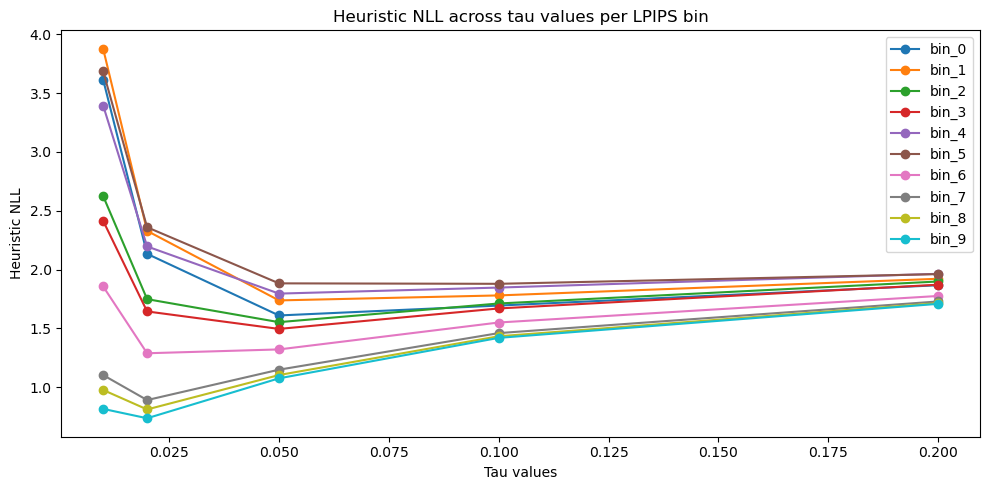

In [16]:
# plot it like a graoh tau on x axis and NLL on y axis for each bin
plt.figure(figsize=(10, 5))
for b in range(num_bins):
    plt.plot(tau_list, nll_various_taus[:, b], marker="o", label=f"bin_{b}")
plt.xlabel("Tau values")
plt.ylabel("Heuristic NLL")
plt.title("Heuristic NLL across tau values per LPIPS bin")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# log the lowest NLL achieved for each bin
print("\nLowest NLL achieved per bin:")
for b in range(num_bins):
    lo, hi = float(bin_edges[b]), float(bin_edges[b+1])
    best_nll = np.nanmin(nll_various_taus[:, b])
    print(f"bin={b:02d} loss[{lo:.3f},{hi:.3f}] best_nll={best_nll:.04f}")


Lowest NLL achieved per bin:
bin=00 loss[0.021,0.127] best_nll=1.6099
bin=01 loss[0.127,0.232] best_nll=1.7379
bin=02 loss[0.232,0.338] best_nll=1.5530
bin=03 loss[0.338,0.444] best_nll=1.4955
bin=04 loss[0.444,0.550] best_nll=1.7957
bin=05 loss[0.550,0.656] best_nll=1.8790
bin=06 loss[0.656,0.762] best_nll=1.2886
bin=07 loss[0.762,0.867] best_nll=0.8906
bin=08 loss[0.867,0.973] best_nll=0.8109
bin=09 loss[0.973,1.079] best_nll=0.7361


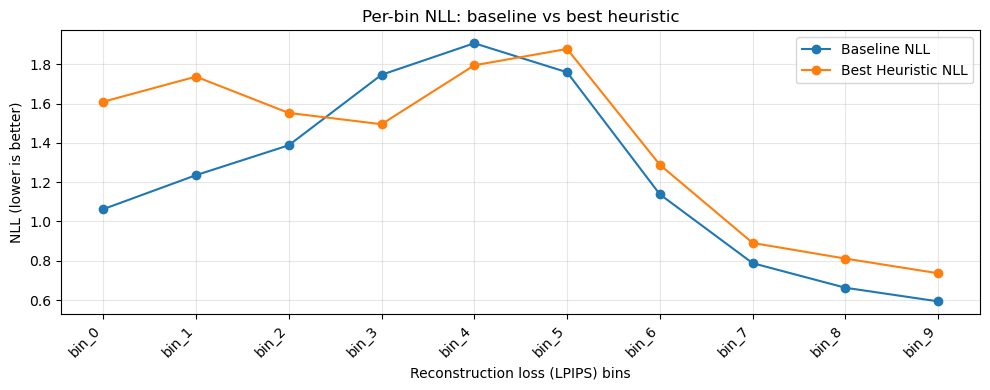

In [ ]:
# plot this against the baseline NLL
best_nlls = [np.nanmin(nll_various_taus[:, b]) for b in range(num_bins)]
deltas = [rows_baselines[b]['baseline_nll'] - best_nlls[b] for b in range(num_bins)]    
plt.figure(figsize=(10, 4))
plt.plot(range(num_bins), [rows_baselines[b]['baseline_nll'] for b in range(num_bins)], marker="o", label="Baseline NLL")
plt.plot(range(num_bins), best_nlls, marker="o", label="Best Heuristic NLL")
plt.xticks(range(num_bins), [f"bin_{i}" for i in range(num_bins)], rotation=45, ha="right")
plt.xlabel("Reconstruction loss (LPIPS) bins")
plt.ylabel("NLL (lower is better)")
plt.title("Per-bin NLL: baseline vs best heuristic")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# take the count into account in comparison
weighted_delta_nll = sum(d * counts_per_bin[b] for b, d in enumerate(deltas) if not np.isnan(d))
total_counts = sum(counts_per_bin)
avg_weighted_delta_nll = weighted_delta_nll / total_counts if total_counts > 0 else float('nan')
print(f"\nAverage weighted delta NLL (baseline - best heuristic): {avg_weighted_delta_nll:.4f}")    


Average weighted delta NLL (baseline - best heuristic): 0.0051


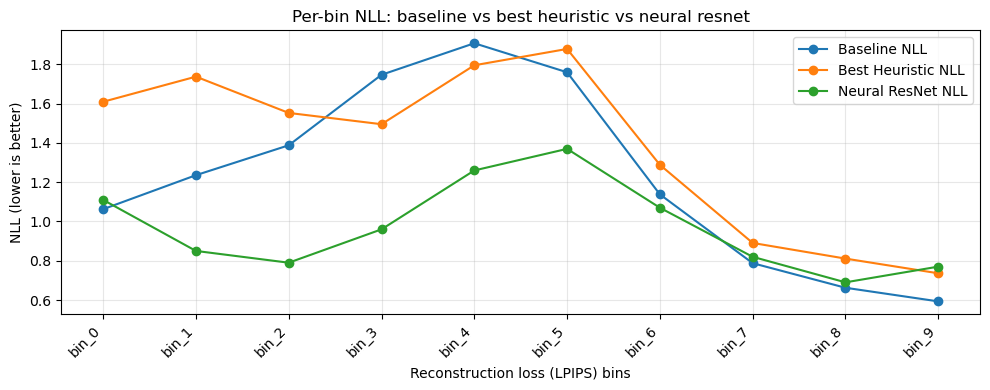

In [ ]:
neural_resnet = [1.11, 0.85, 0.79, 0.96, 1.26, 1.37, 1.07, 0.82, 0.69, 0.77]
# include the neural resnet values in the plot
plt.figure(figsize=(10, 4))
plt.plot(range(num_bins), [rows_baselines[b]['baseline_nll'] for b in range(num_bins)], marker="o", label="Baseline NLL")
plt.plot(range(num_bins), best_nlls, marker="o", label="Best Heuristic NLL")
plt.plot(range(num_bins), neural_resnet, marker="o", label="Neural ResNet NLL")
plt.xticks(range(num_bins), [f"bin_{i}" for i in range(num_bins)], rotation=45, ha="right")
plt.xlabel("Reconstruction loss (LPIPS) bins")
plt.ylabel("NLL (lower is better)")
plt.title("Per-bin NLL: baseline vs best heuristic vs neural resnet")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
bin=0 | n=816 | heuristic_nll=3.6143
bin=1 | n=9841 | heuristic_nll=3.8768
bin=2 | n=43865 | heuristic_nll=2.6247
bin=3 | n=96329 | heuristic_nll=2.4143
bin=4 | n=120271 | heuristic_nll=3.3943
bin=5 | n=123476 | heuristic_nll=3.6844
bin=6 | n=51208 | heuristic_nll=1.8566
bin=7 | n=3892 | heuristic_nll=1.1030
bin=8 | n=277 | heuristic_nll=0.9764
bin=9 | n=25 | heuristic_nll=0.8157

In [ ]:
# plot heat map for amount of instances per each bin